In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import textblob

import data
import plot

Takes a 5 minutes the first time, but use `use_cached` afterward so you don't have to wait in the future.

In [2]:
train, test = data.get_data(use_cached=True)

Using Cached


In [ ]:
# train['change_in_polarity'] = train.groupby([train.index.get_level_values(0), 'person'])['polarity'].diff()

# shift_list = ['polarity', 'subjectivity', 'change_in_polarity', 'act', 'emo']
# for label in shift_list:
#     train['heard_' + label] = train.groupby([train.index.get_level_values(0)])[label].shift()

# train = pd.concat([train, pd.get_dummies(train[['heard_act', 'heard_emo']])], axis=1)

# Goals of Exploration
- Plot some conversation samples
- Observe and explore why 3 of the major changes in conversations happened?
    - Topics
    - Replies

## Taking a look at a few random conversations

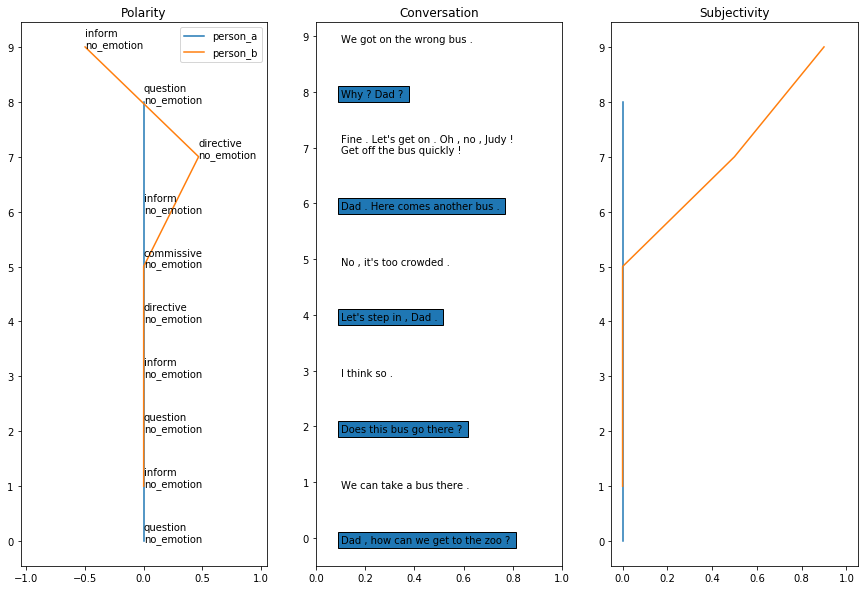

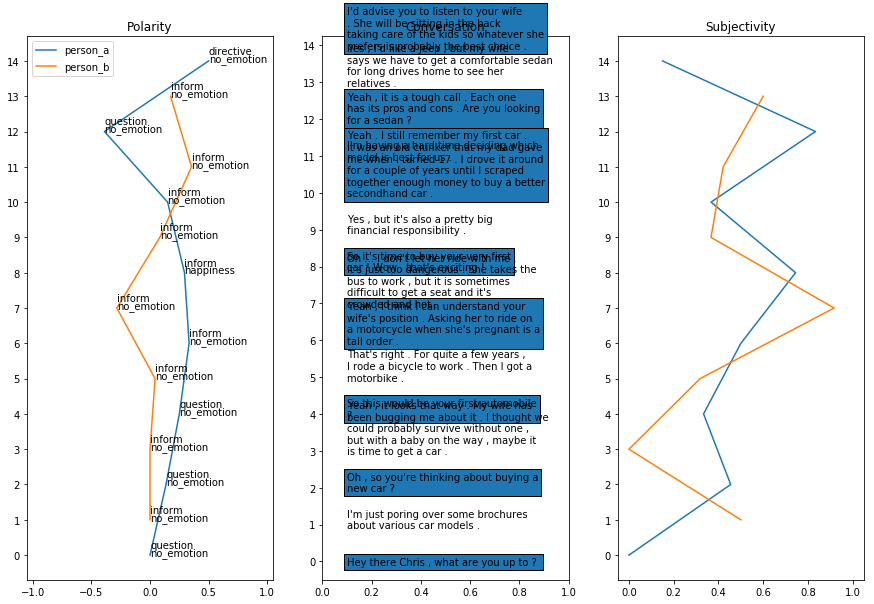

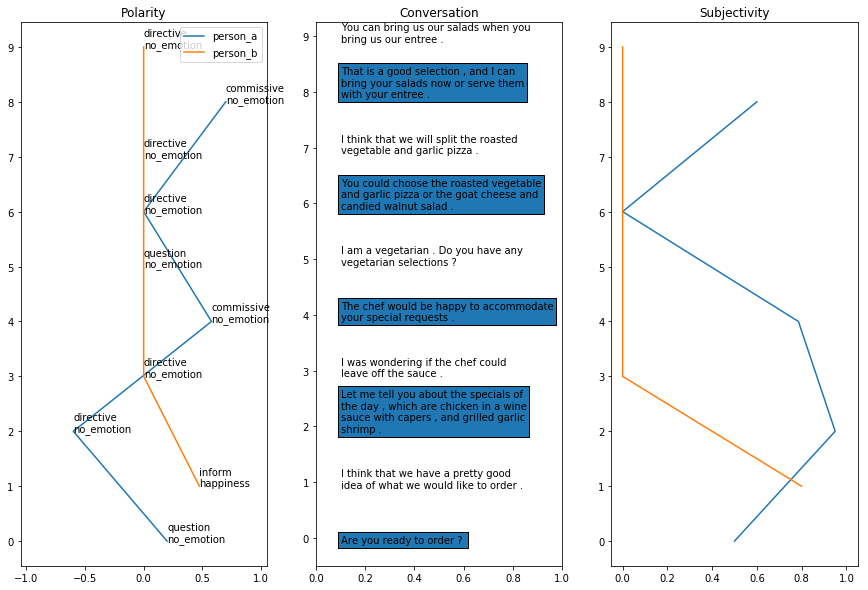

In [5]:
values = set(train.index.get_level_values(0))
num_convs = len(values)
conv_ids = np.random.randint(0, num_convs, 3)
for conv_id in conv_ids:
    plot.plot_conv(train.loc[conv_id])

## Looking at examples that had the largest change in sentiment (up and then down)

In [6]:
num = 30

indices = list(train.sort_values('biggest_drawup', axis=0, ascending=False).index.get_level_values(0).unique())
biggest_drawup = train.loc[indices[:num]]

indices = list(train.sort_values('biggest_drawdown', axis=0, ascending=True).index.get_level_values(0).unique())
biggest_drawdown = train.loc[indices[:num]]

plt.close()

### EDA on top `num` Conversations that had the largest drawup in sentiment

From these plots it looks like there is some correlation between change in polarity between persons. 

Really, it would be best to just look at correlation between change in polarity and all other variables since we have them!

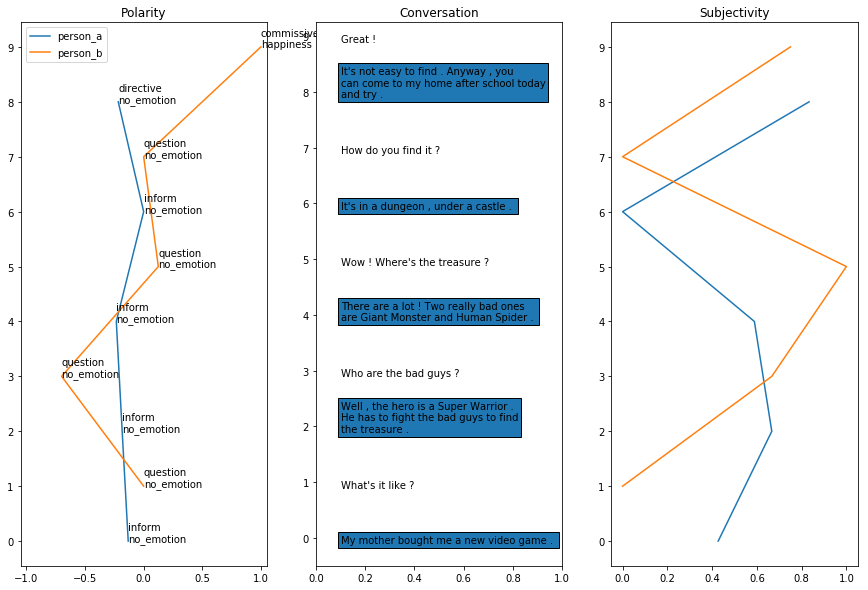

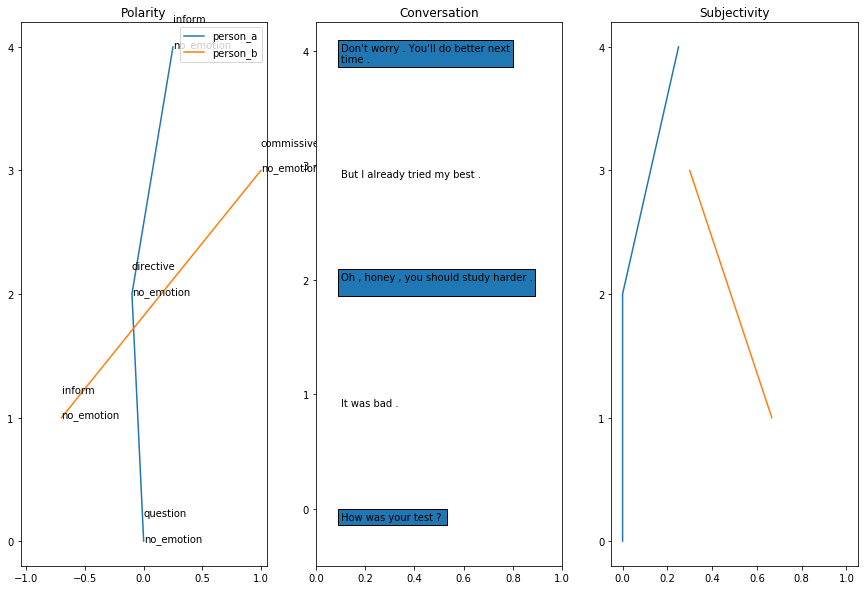

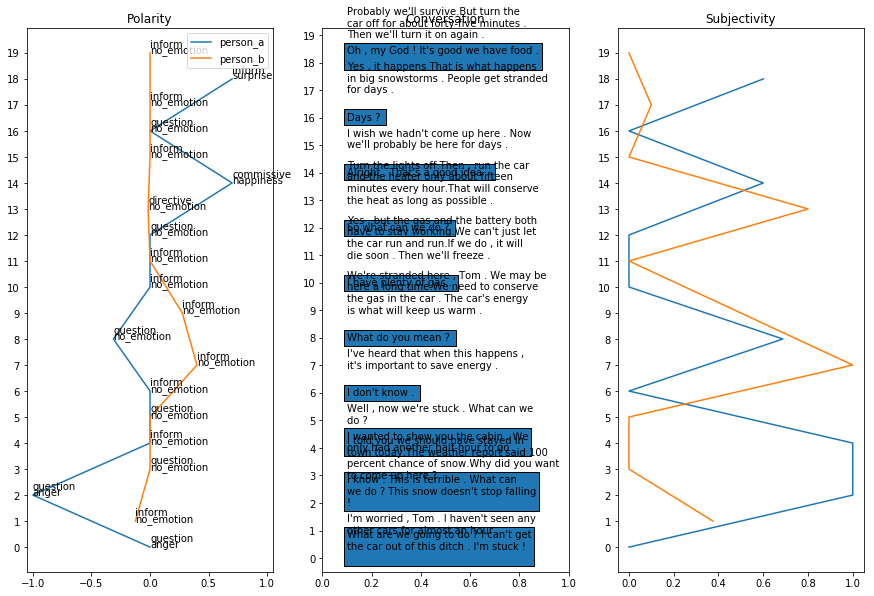

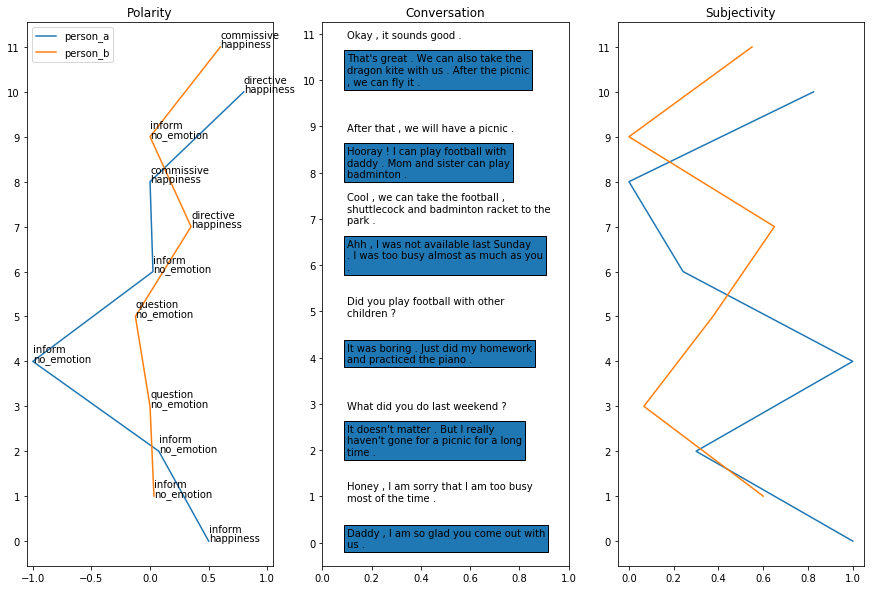

In [6]:
for loc in biggest_drawup.index.get_level_values(0).unique()[:4]:
    plot.plot_conv(biggest_drawup.loc[loc])

In [114]:
biggest_drawup.head(1)

,,person,utter,act,emo,polarity,subjectivity,topic,change_in_polarity,biggest_drawup,biggest_drawdown,...,heard_act_directive,heard_act_inform,heard_act_question,heard_emo_anger,heard_emo_disgust,heard_emo_fear,heard_emo_happiness,heard_emo_no_emotion,heard_emo_sadness,heard_emo_surprise
conv,,,,,,,,,,,,,,,,,,,,,,
47,0,person_a,My mother bought me a new video game .,inform,no_emotion,-0.131818,0.427273,ordinary_life,NaN,0.233333,-0.216667,...,0,0,0,0,0,0,0,0,0,0


### NOTE

`heard` prefix simply means that this is what the person heard; if the previous utterance had `no emotion | directive`, that is what would show up in this column.

#### corrplot

### Corrplot against conversations that had the largest `drawup` in sentiment

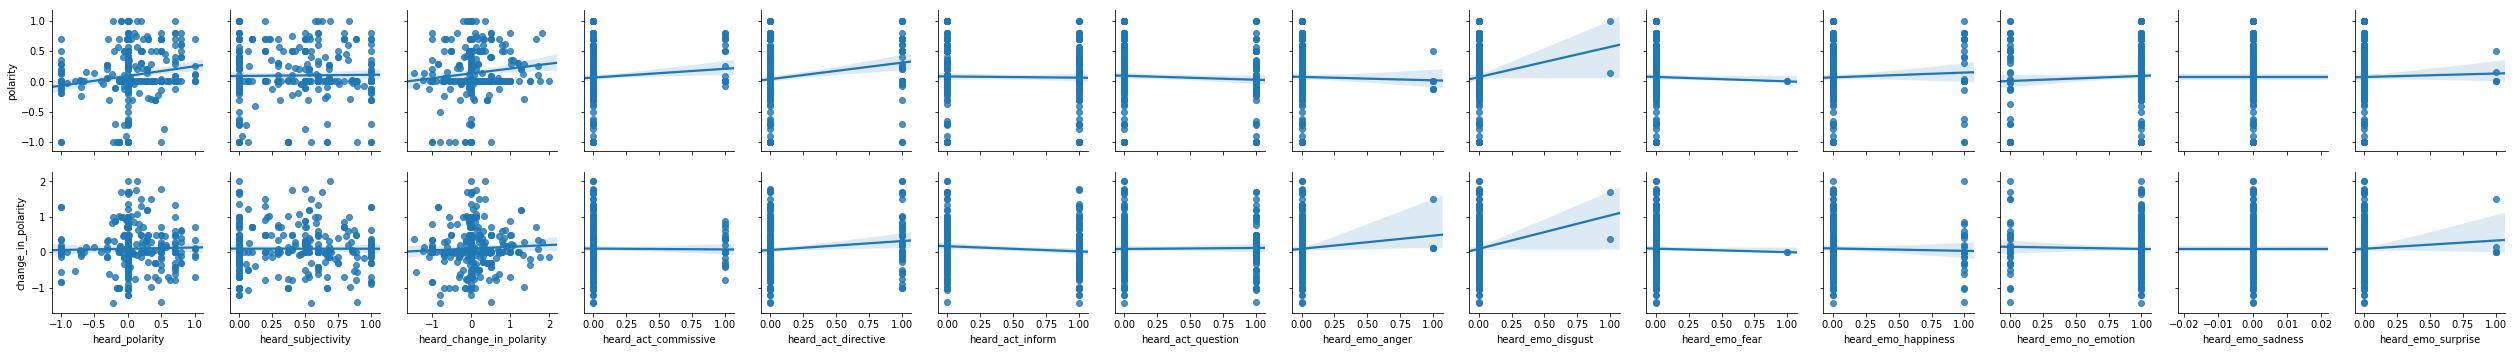

In [19]:
def corrplot(df, y_vars=['polarity', 'change_in_polarity']):
    x_vars = [i for i in df.columns if 'heard_' in i and i not in {'heard_act', 'heard_emo', 'heard_utter'}]
    sns.pairplot(df[y_vars + x_vars],
                 kind='reg',
                 y_vars=y_vars,
                 x_vars=x_vars)
corrplot(biggest_drawup)

There's definitely SOME signal in there.

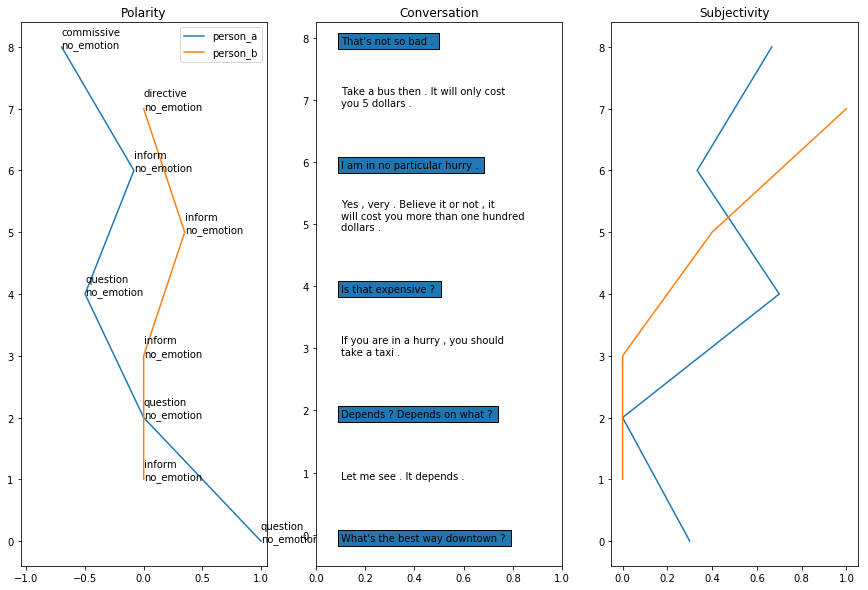

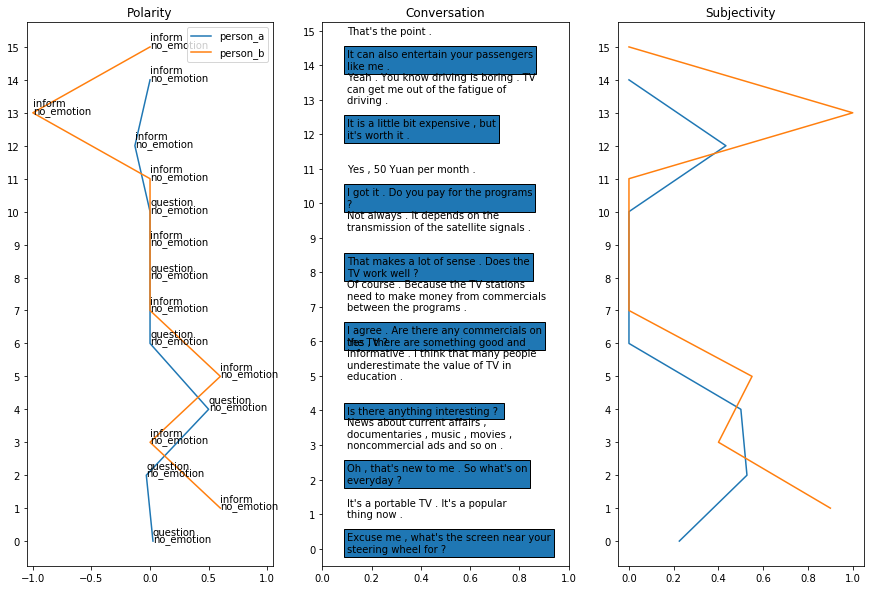

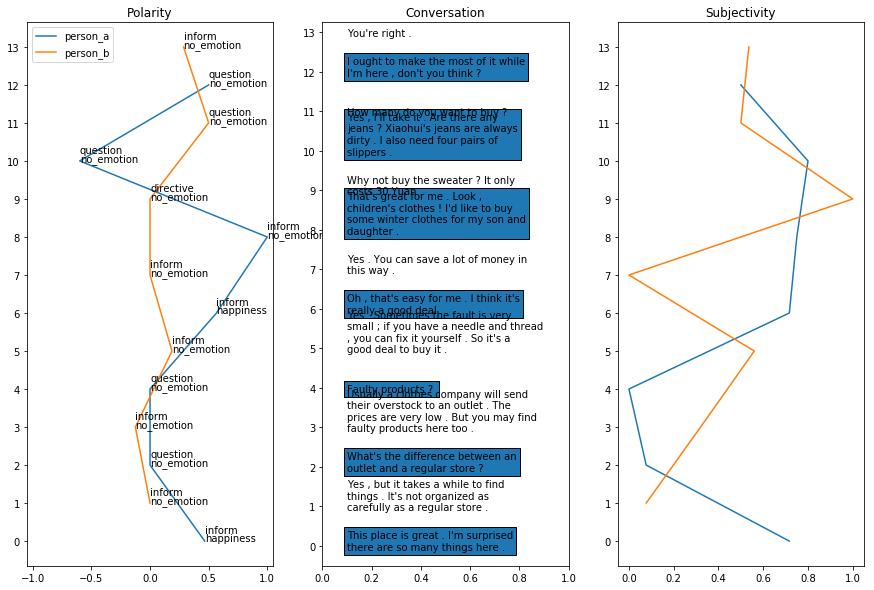

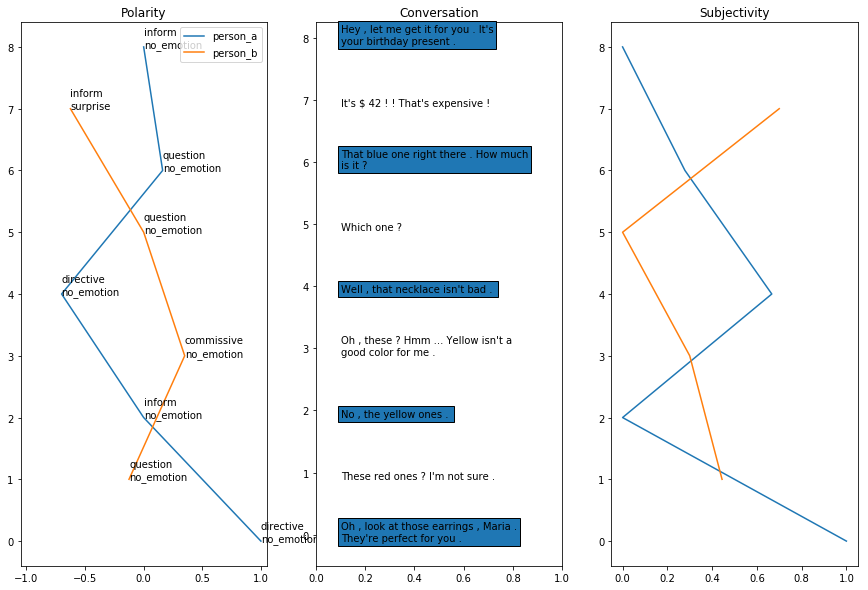

In [10]:
for loc in biggest_drawdown.index.get_level_values(0).unique()[:4]:
    plot.plot_conv(biggest_drawdown.loc[loc])

### Corrplot against conversations that had the largest `drawdown` in sentiment

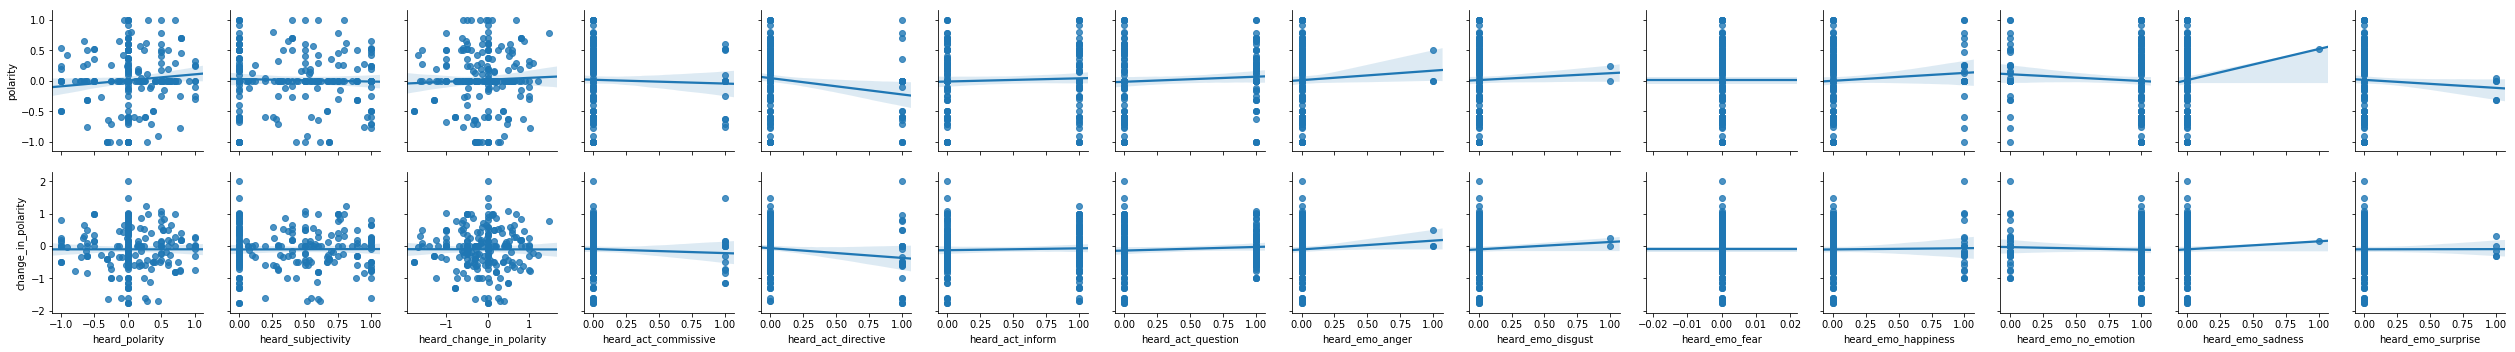

In [11]:
corrplot(biggest_drawdown)

### Take a look at random samples

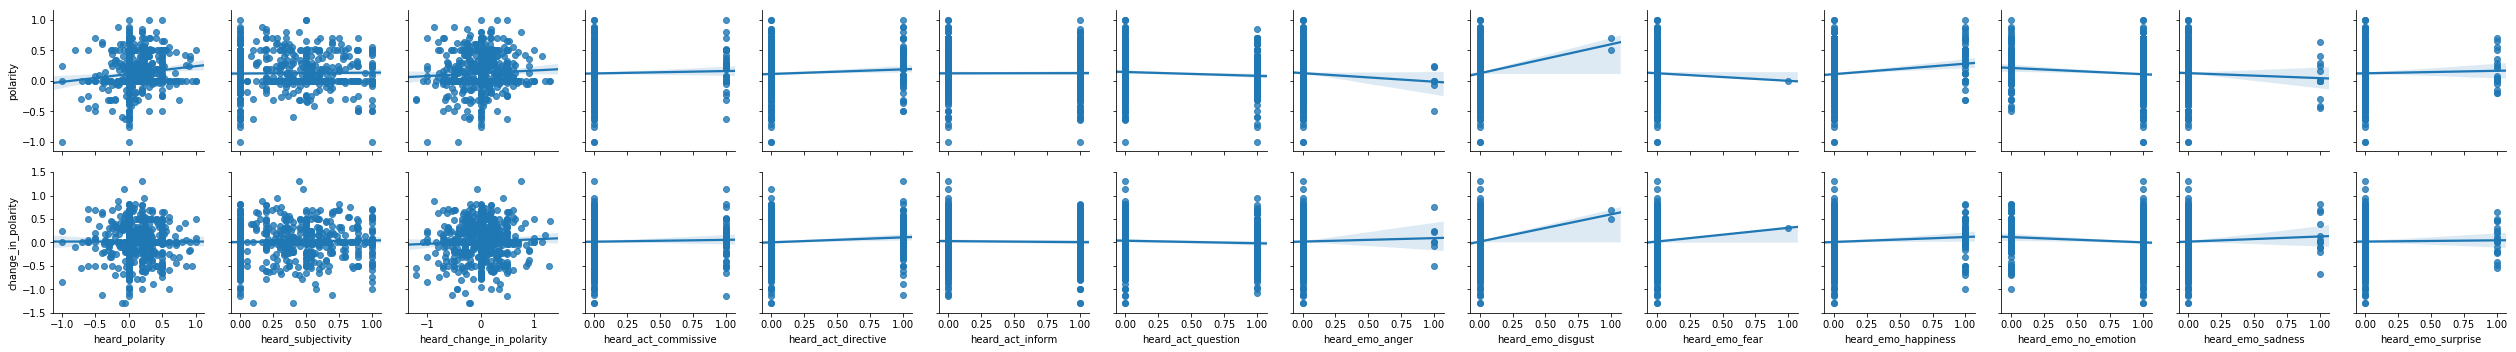

In [113]:
corrplot(train.sample(1000))

### Thoughts on observations

It looks like `heard_change_in_polarity` and `heard_polarity` (redundant obviously to some degree) both affect the next utterances polarity to some degree

It appears that most of the heard emotions and acts don't seem to have an effect en masse. This also doesn't consider all of the combinations of acts and emotions. 

The first two models I want to try are a linear model only including `heard_change_in_polarity` or `heard_polarity` (whichever has the largest effect. I will consider 

### Corrplots for various instances:
- each topic

### Modeling steps

There are so many combinations of categorical variables. It's seeming like now it makese sense to try either a RandomForest or GradientBoostedTree to get an idea about feature importance. 

ordinary_life


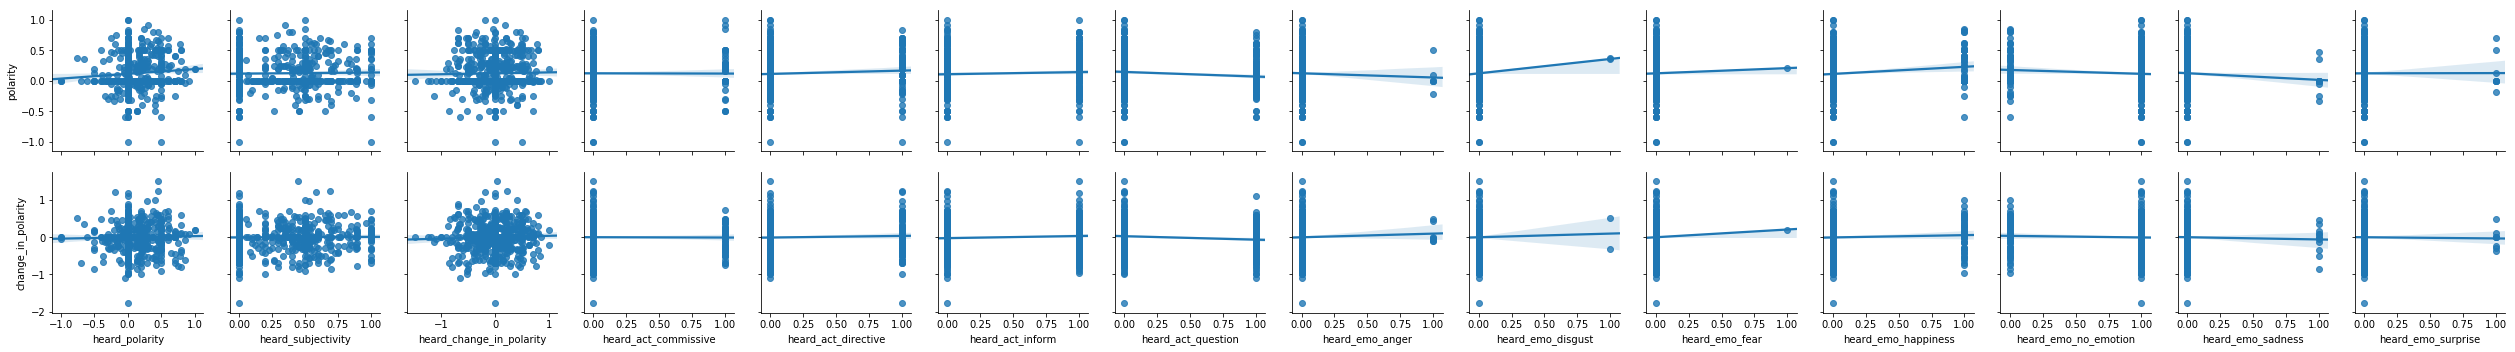

school_life


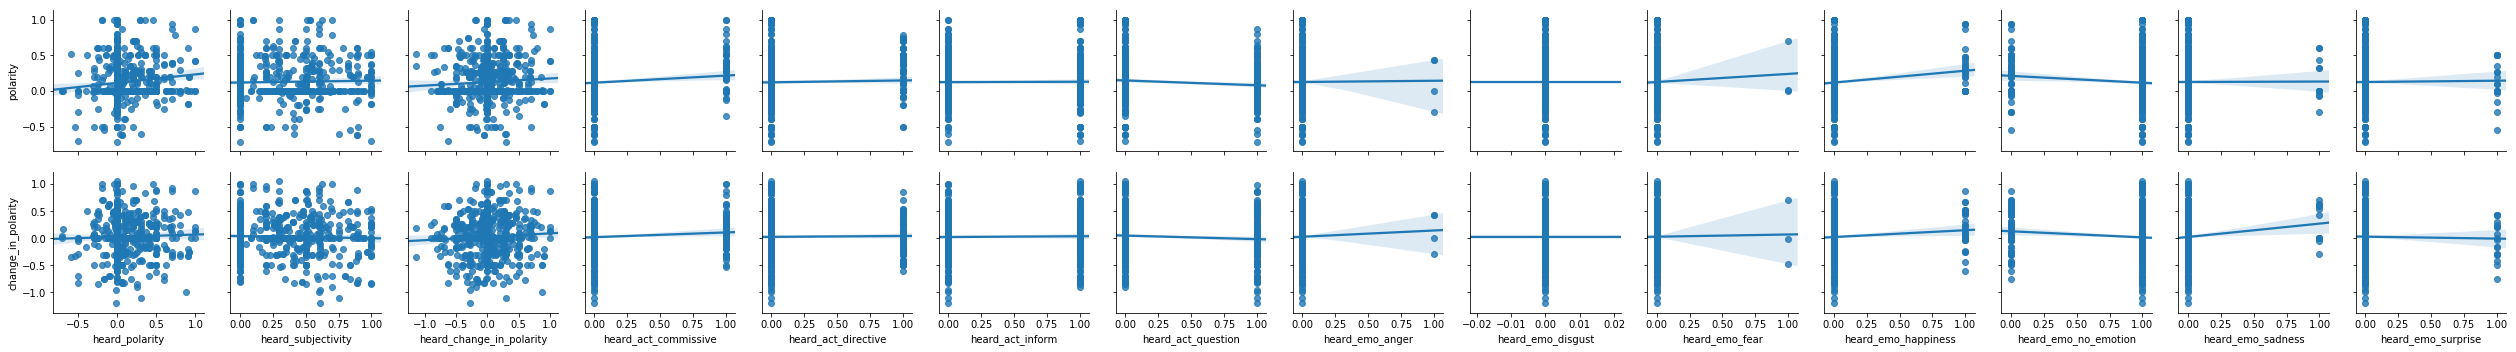

culture_education


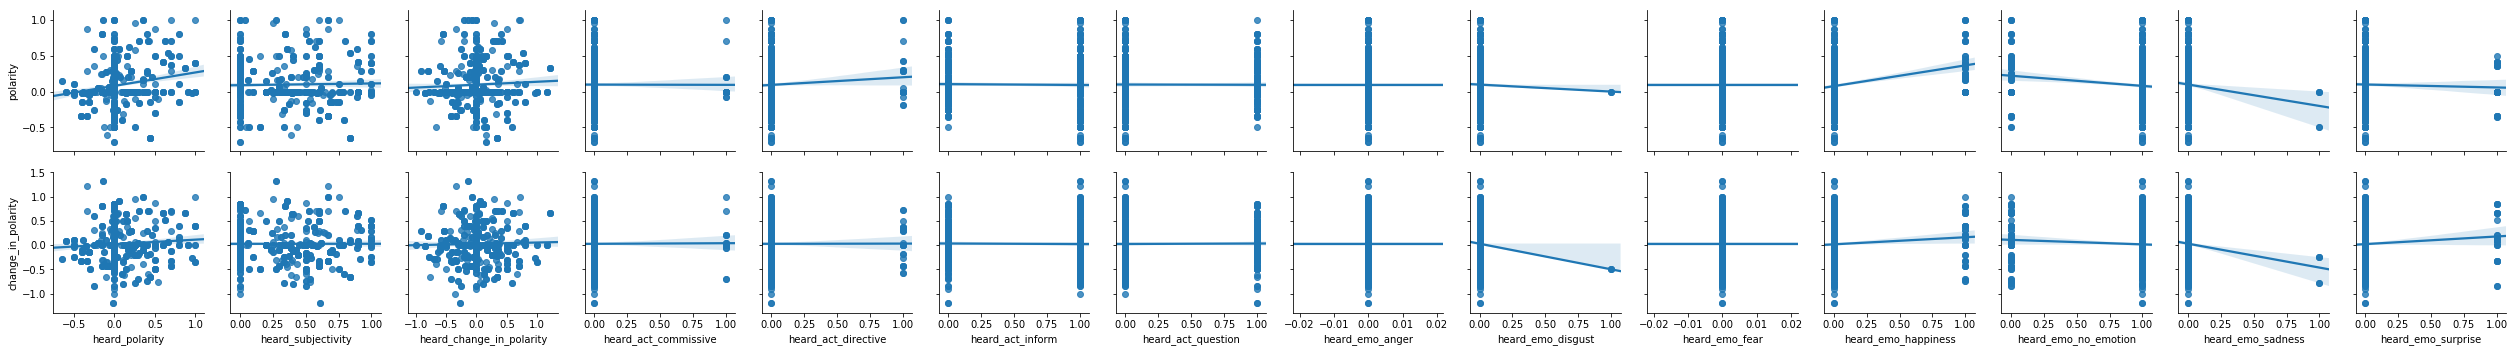

attitude_emotion


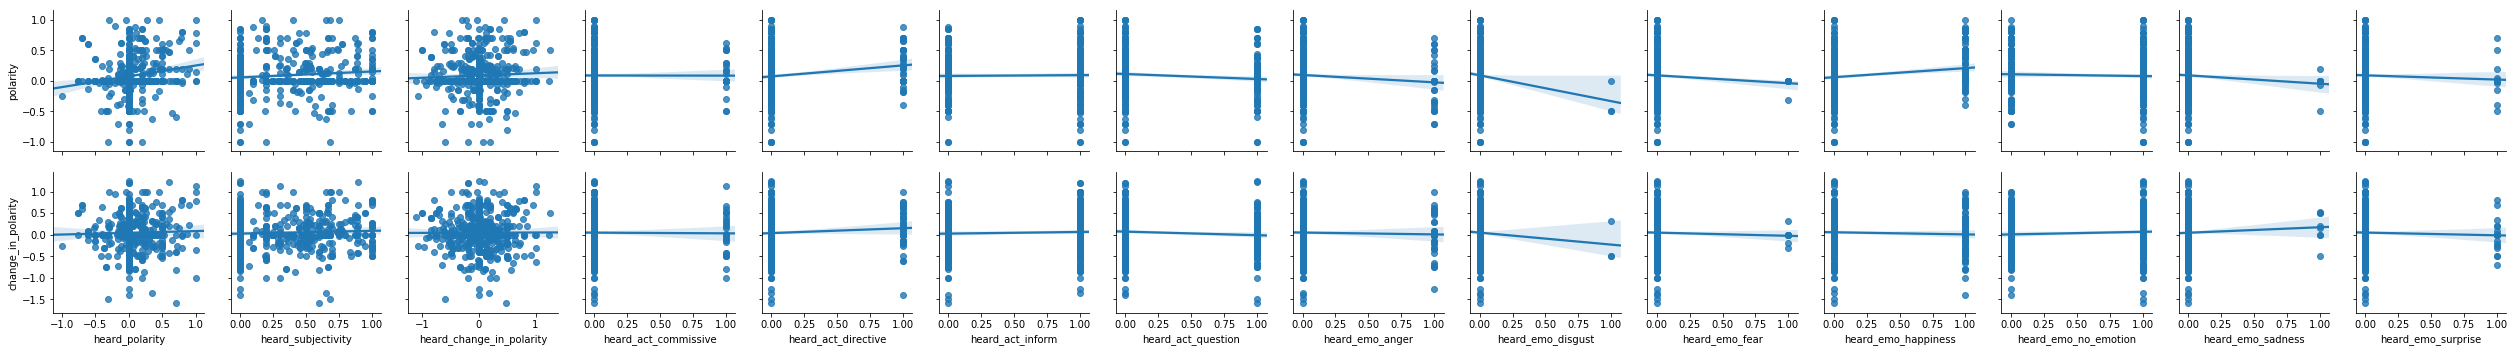

relationship


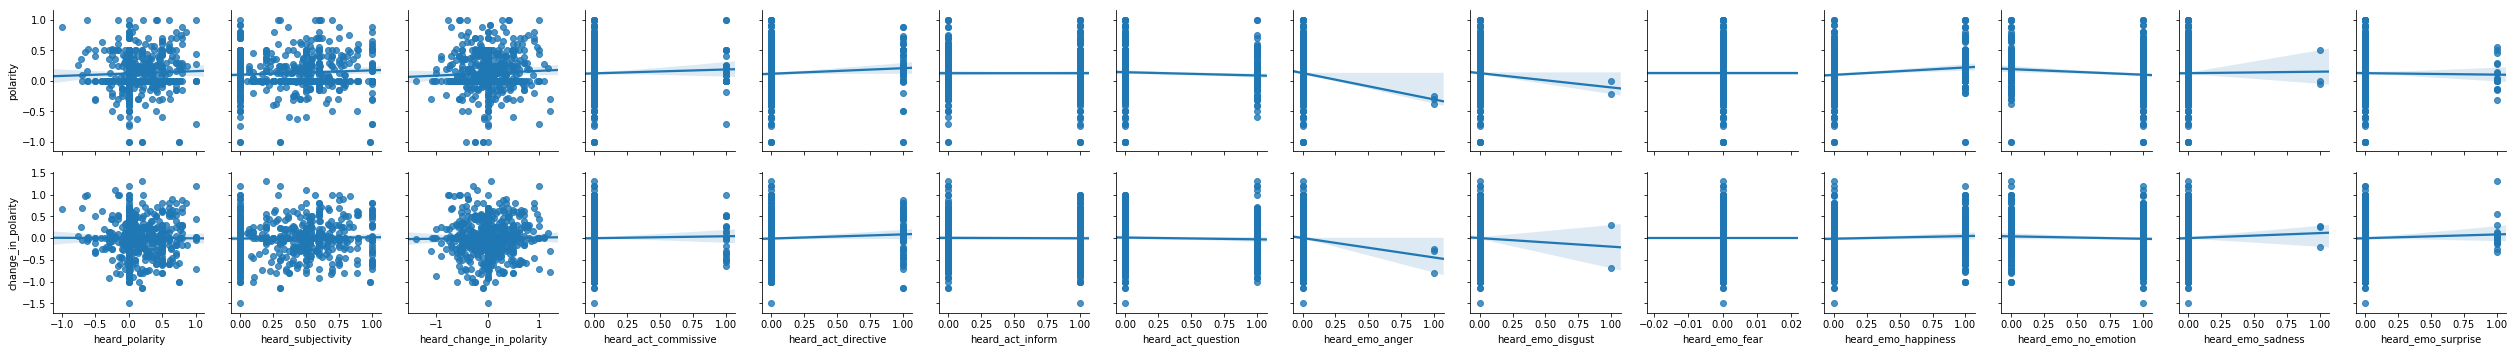

tourism


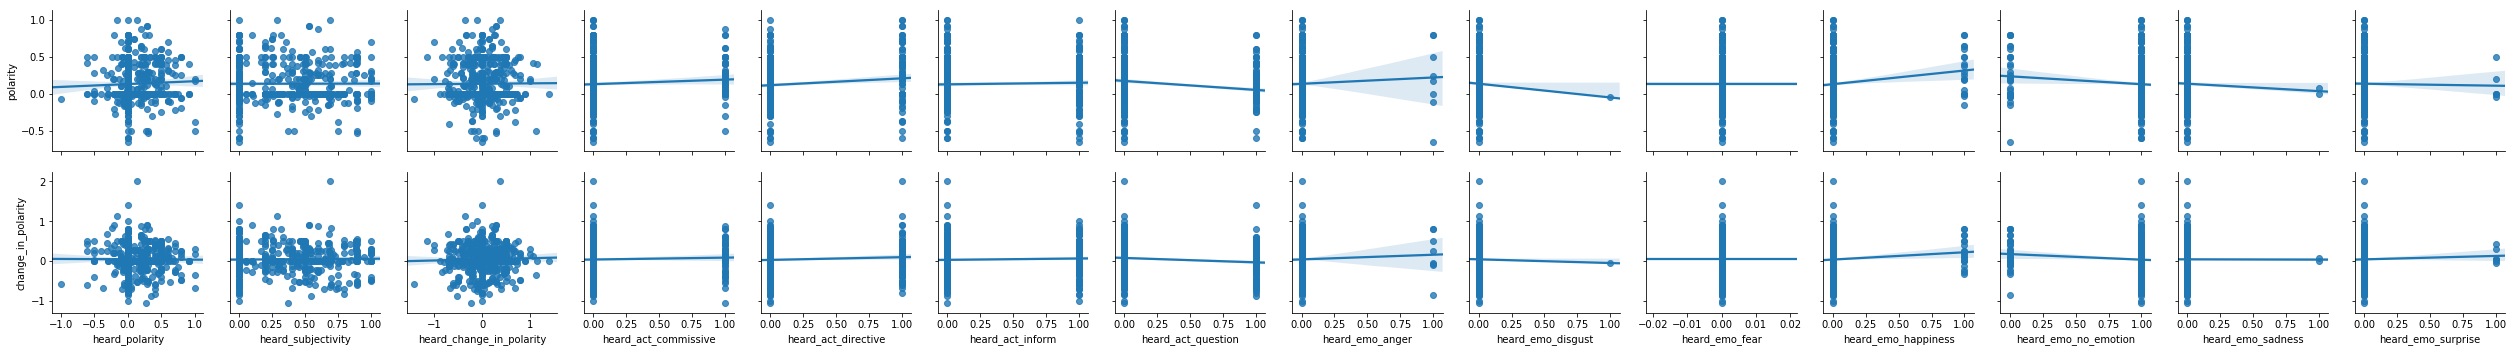

health


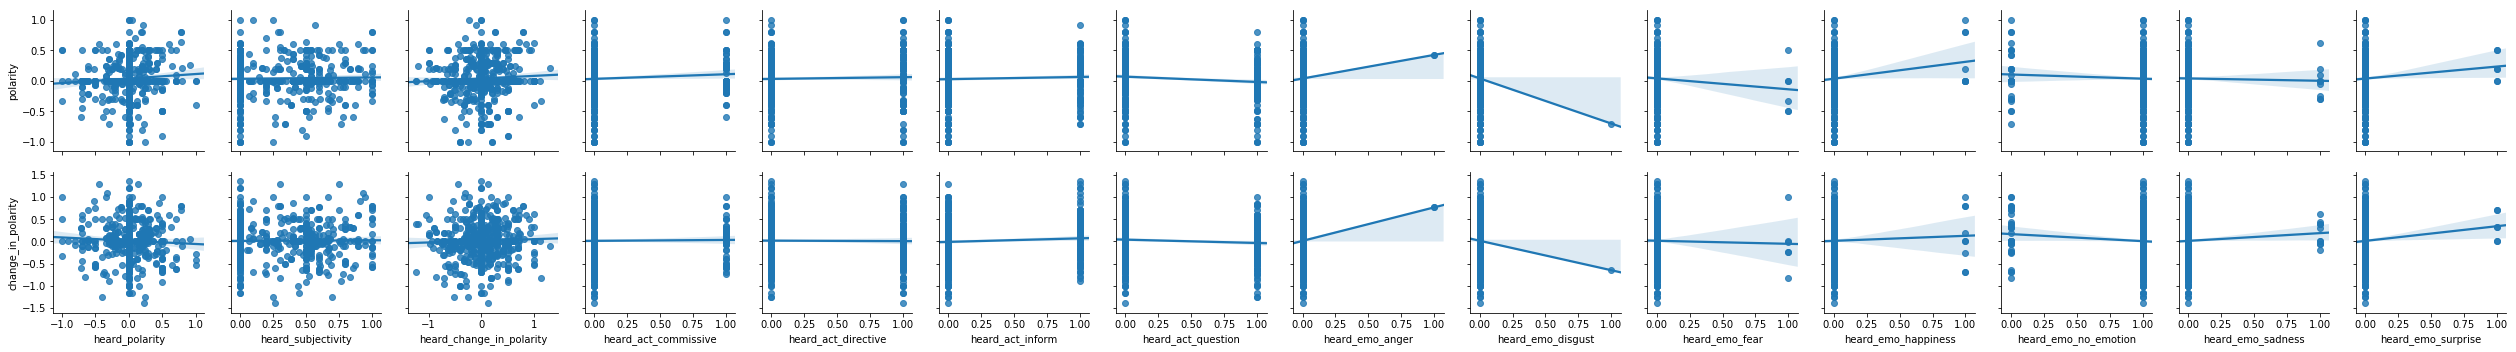

work


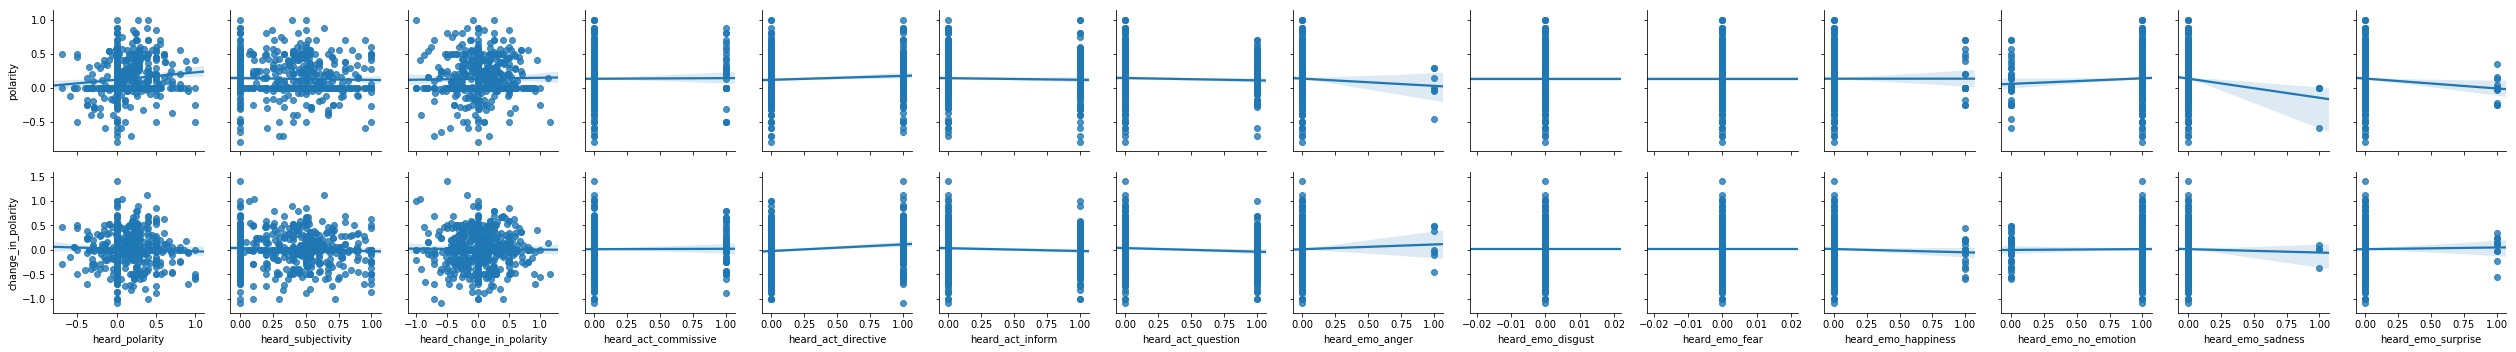

politics


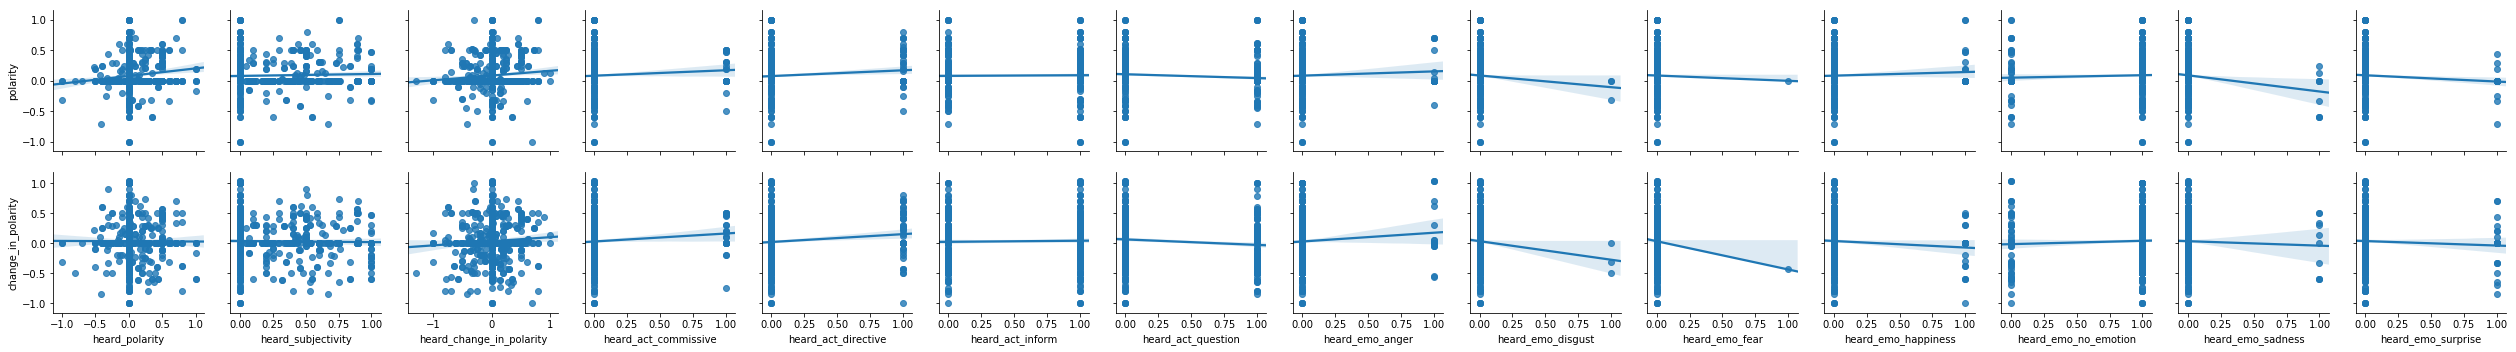

finance


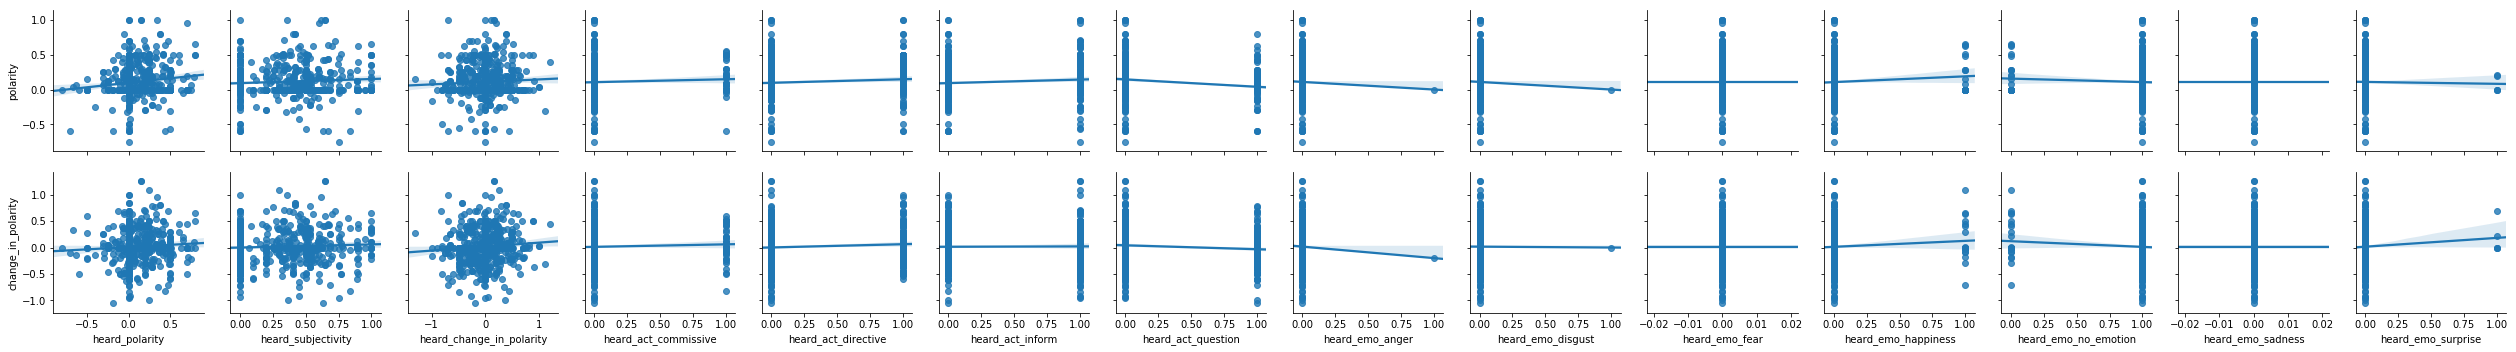

In [13]:
topics = train['topic'].unique()

for topic in topics:
    print(topic)
    corrplot(train[train['topic'] == topic].sample(1000, replace=True))
    plt.show()

In [14]:
plt.close()

# Random Forest Model to help with feature discovery

Although, given how sparse the data is, `Bayesian ridge regression` might be good to try also

In [3]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.decomposition import TruncatedSVD

from sklearn.pipeline import Pipeline

In [4]:
y_MASK = ['polarity']
X_MASK = [i for i in train.columns if i not in ['person', 'utter', 'act', 'emo',
                                                'polarity', 'subjectivity',
                                                'heard_subjectivity', 'heard_change_in_polarity',
                                                'heard_act', 'heard_emo', 'biggest_drawup',
                                                'biggest_drawdown', 'heard_utter', 'topic', 'change_in_polarity']]

NULL_MASK = train['heard_polarity'].notnull().as_matrix()
train_no_nulls = train[y_MASK + X_MASK].reset_index().drop(['conv', 'level_1'], axis=1)
train_no_nulls = train_no_nulls[NULL_MASK]
y = train_no_nulls[y_MASK].as_matrix().ravel()
X = train_no_nulls[X_MASK].as_matrix()

### Random Forest Regressor with just our features

In [5]:
models = [RandomForestRegressor(n_jobs=-1, n_estimators=10)]
#           GradientBoostingRegressor()]
scores = [cross_val_score(model, X, y, cv=5, n_jobs=1).mean() for model in models]

In [6]:
scores

[-0.04075496982981437]

:(

##### RF Regressor with compressed text features from conversation (latent semantic analysis)

In [33]:
def tokenizer(string):
    string = string.lower().strip()
    string = ' '.join(string.split(','))
    string = ' '.join(string.split('.'))
    return string.split(' ')

vectorizer = TfidfVectorizer(tokenizer=tokenizer)
bag_of_words = vectorizer.fit_transform(train['heard_utter'][NULL_MASK])

In [34]:
svd = TruncatedSVD(n_components=100)
lsi = svd.fit_transform(bag_of_words)

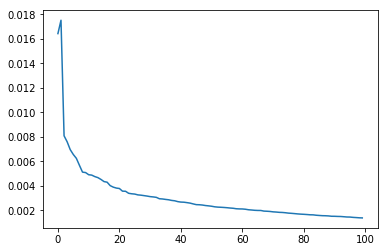

In [42]:
plt.plot(svd.explained_variance_)

Perhaps let's just use like 20 components

In [43]:
svd = TruncatedSVD(n_components=20)
lsi = svd.fit_transform(bag_of_words)

In [44]:
X_w_lsi = np.append(X, lsi, axis=1)

In [45]:
X_w_lsi.shape

(83236, 42)

In [46]:
models = [RandomForestRegressor(n_jobs=-1, n_estimators=10)]
#           GradientBoostingRegressor()]
scores2 = [cross_val_score(model, X_w_lsi, y, cv=5, n_jobs=1).mean() for model in models]

In [51]:
scores2

[-0.00045512672761889307]

In [48]:
model = RandomForestRegressor(n_jobs=-1, n_estimators=10)
model.fit(X_w_lsi, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

This is quite interesting if you look at the feature importances.

The decomposed bag of words matrix (i.e. the words /concepts themselves... (go figure) ) contribute more to being able to predict the sentiment(polarity). 

In [49]:
X.shape, lsi.shape

((83236, 22), (83236, 20))

features 1 through 22 are features we created. features 23 through ~44 are components of LSI

<BarContainer object of 42 artists>

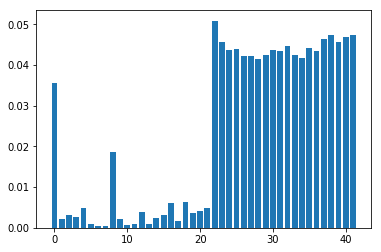

In [50]:
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)

In [97]:
X_MASK[0], X_MASK[8], '22 through 41 are components from SVD'

('heard_polarity',
 'heard_emo_happiness',
 '22 through 41 are components from SVD')

In [98]:
from sklearn.svm import SVR

In [99]:
models = [SVR()]
#           GradientBoostingRegressor()]
scores3 = [cross_val_score(model, X_w_lsi, y, cv=5, n_jobs=1).mean() for model in models]
scores3

KeyboardInterrupt: 

### What I know thus far:
- Our meta features aren't much help. 
- LSI of text was more useful.
- More exploration needed.

:(

# Feature Selection:

- follow these for inspiration: 
    - http://doras.dcu.ie/16194/2/A_Study_on_Mutual_Information-based_Feature_Selection_for_Text_Categorization.pdf
    - http://www.lrec-conf.org/proceedings/lrec2014/pdf/292_Paper.pdf

# Archived notes

### The parser suggested by Loris was not random if you look at the topic distribution

Just taking a brief look at the topic distribution. It appears that it's not even for each test set. 

In [3]:
train['topic'].unique(), validation['topic'].unique(), test['topic'].unique()

(array(['ordinary_life', 'school_life', 'culture_education',
        'attitude_emotion', 'relationship', 'tourism', 'health', 'work'],
       dtype=object),
 array(['work'], dtype=object),
 array(['work', 'politics', 'finance'], dtype=object))

Yeah the original dataset is simply sorted topics. I can't trust the topics. Not only that, they aren't really meaningful from one dataset to the next.

In [4]:
topics = pd.read_csv('data/ijcnlp_dailydialog/dialogues_topic.txt') # original unparsed
topics = topics['1']

print('Train dataset unique: {}\n'.format(topics[0:11118].unique()))
print('Validation dataset unique: {}\n'.format(topics[11118:12118].unique()))
print('Test dataset unique: {}\n'.format(topics[12118: 13118].unique()))

Train dataset unique: [1 2 3 4 5 6 7 8]

Validation dataset unique: [8]

Test dataset unique: [ 8  9 10]



##### Not going to use Topics for now. 